# Word2Vec and BERT Model Training and Comparison (version 0)

## Objective
This script preprocesses three corpora (BNC, FCL, Legislation), trains Word2Vec and BERT models,
evaluates them using synonym similarity, and analses semantic shifts across corpora.
It includes corpus pre-processing, semantic shift analysis, and three
semantic search prototypes: Word2Vec based, and 2 BERT based protoypes (1 with keyword detection).


In [1]:
# Import Libraries
import spacy, time, requests, os, itertools, json, re, pickle, torch, itertools, nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from gensim.matutils import unitvec
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup
from scipy.spatial.distance import cosine
from statistics import mean
from collections import Counter, defaultdict
from html import unescape
from tqdm import tqdm
from scipy.spatial.distance import cosine, euclidean
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel

# STEP 1: Corpus preprocessing 

In [2]:
# Load spaCy Model
nlp = spacy.load("en_core_web_sm")

In [6]:
def clean_text(text):
    # Remove XML tags using BeautifulSoup
    clean_text = BeautifulSoup(text, "html.parser").get_text()
    
    # Split words where lowercase is followed by uppercase
    clean_text = re.sub(r'([a-z])([A-Z])', r'\1 \2', clean_text)

    # Additional cleaning: normalize whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

In [7]:
def process_text_in_chunks(text, chunk_size=100_000, min_token_length=3, stoplist=None):
    """Function to process text in manageable chunks, with better handling of tokens."""
    if stoplist is None:
        stoplist = set()

    # First clean the text to fix concatenation issues
    text = clean_text(text)
    
    tokens = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i + chunk_size].lower()
        doc = nlp(chunk)
        
        # Add lemmatized tokens while filtering out unwanted tokens
        chunk_tokens = []
        for token in doc:
            # Only include proper tokens
            if (token.is_alpha and 
                not token.is_stop and 
                len(token.text) >= min_token_length and
                token.lemma_.lower() not in stoplist):
                
                # Additional check for concatenated words that might have been missed
                lemma = token.lemma_.lower()
                if re.search(r'[a-z][A-Z]', lemma):
                    # Skip concatenated words that weren't properly split
                    continue
                    
                chunk_tokens.append(lemma)
                
        tokens.extend(chunk_tokens)
    
    return tokens

In [8]:
# Stoplist of terms to filter out
stoplist = {
    "listitem", 'itemlistelement', 'breadcrumblist', "legaldocml", "xml", 
    "pdf", "doc", "download", "govuk", "http", "https", "www", "html", 
    "paragraph", "section", "subsection", "appendix",
    "page", "footnote", "endnote", "header", "footer",
    "anor", "ewhc", "fam", "lawbeta", "nomodule", "frontend"}

### Find Case Law corpus (EWHC Family division)
Call Find Case Law API, information here: https://nationalarchives.github.io/ds-find-caselaw-docs/public

In [9]:
# loading FCL corpus from API
api_url = "https://caselaw.nationalarchives.gov.uk/atom.xml"

In [10]:
#configuration API settings
total_pages = 1338 # Total number of pages
per_page = 50    # Number of cases per page
delay = 1         # Delay between requests to avoid rate limiting

In [11]:
# Improved FCL data collection with better error handling and preprocessing
fcl_data = []
for page in range(1, total_pages + 1):
    print(f"Fetching page {page} of {total_pages}...")

    try:
        response = requests.get(api_url, params={'page': page, 'per_page': per_page, 'order': '-date'})
        response.raise_for_status()  # Raise exception for HTTP errors
        
        soup = BeautifulSoup(response.text, "xml")
        for entry in soup.find_all("entry"):
            try:
                case_link = entry.find("link", {"rel": "alternate"})["href"]
                case_response = requests.get(case_link)
                case_response.raise_for_status()

                case_text = BeautifulSoup(case_response.text, "xml").get_text()
                processed_text = process_text_in_chunks(case_text, stoplist=stoplist)
                
                # Additional validation to ensure quality
                if processed_text and len(processed_text) > 50:  # Ensure we have enough tokens
                    fcl_data.append(processed_text)
            except Exception as e:
                print(f"Error processing case: {e}")
    except Exception as e:
        print(f"Error fetching page {page}: {e}")

    time.sleep(delay)  # Avoid overwhelming the server

Fetching page 1 of 1338...
Fetching page 2 of 1338...
Fetching page 3 of 1338...
Fetching page 4 of 1338...
Fetching page 5 of 1338...
Fetching page 6 of 1338...
Fetching page 7 of 1338...
Fetching page 8 of 1338...
Fetching page 9 of 1338...
Fetching page 10 of 1338...
Fetching page 11 of 1338...
Fetching page 12 of 1338...
Fetching page 13 of 1338...
Fetching page 14 of 1338...
Fetching page 15 of 1338...
Fetching page 16 of 1338...
Fetching page 17 of 1338...
Fetching page 18 of 1338...
Fetching page 19 of 1338...
Fetching page 20 of 1338...
Fetching page 21 of 1338...
Fetching page 22 of 1338...
Fetching page 23 of 1338...
Fetching page 24 of 1338...
Fetching page 25 of 1338...
Fetching page 26 of 1338...
Fetching page 27 of 1338...
Fetching page 28 of 1338...
Fetching page 29 of 1338...
Fetching page 30 of 1338...
Fetching page 31 of 1338...
Fetching page 32 of 1338...
Fetching page 33 of 1338...
Fetching page 34 of 1338...
Fetching page 35 of 1338...
Fetching page 36 of 1338...
F

In [12]:
#save corpus to json file
with open("/Users/caitlinwilson/Scripts_Local/corpora/fcl_full_v4.json", 'w', encoding='utf-8') as f:
    json.dump(fcl_data, f, ensure_ascii=False, indent=2)

In [2]:
#load again
with open("/Users/caitlinwilson/Scripts_Local/corpora/fcl_full_v4.json", 'r', encoding='utf-8') as f:
    fcl_data = json.load(f)

In [3]:
print(fcl_data[:5])

[['betta', 'oceanway', 'company', 'tomini', 'trading', 'srl', 'find', 'case', 'law', 'national', 'archive', 'skip', 'main', 'content', 'enable', 'module', 'htmlscript', 'support', 'website', 'use', 'cookie', 'place', 'essential', 'cookie', 'device', 'website', 'work', 'like', 'use', 'additional', 'cookie', 'remember', 'setting', 'understand', 'use', 'service', 'information', 'help', 'improvement', 'website', 'set', 'cookie', 'preference', 'find', 'case', 'law', 'beta', 'judgment', 'decision', 'menu', 'home', 'help', 'guidance', 'breadcrumb', 'list', 'item', 'list', 'element', 'list', 'item', 'position', 'find', 'case', 'law', 'item', 'list', 'item', 'position', 'betta', 'oceanway', 'company', 'tomini', 'trading', 'srl', 'find', 'case', 'law', 'betta', 'oceanway', 'company', 'tomini', 'trading', 'srl', 'research', 'improve', 'find', 'case', 'law', 'service', 'betta', 'oceanway', 'company', 'tomini', 'trading', 'srl', 'ewca', 'civ', 'view', 'option', 'neutral', 'citation', 'number', 'ewc

### British National Corpus
Save XMl files locally from http://www.natcorp.ox.ac.uk/XMLedition/

In [ ]:
def load_and_preprocess_bnc(directory, stoplist=None, verbose=False):
    bnc_data = []

    # Collect all XML file paths first
    xml_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_files.append(os.path.join(root, file))

    print(f"Found {len(xml_files)} BNC XML files. Starting processing...\n")

    for file_path in tqdm(xml_files, desc="Processing BNC files", unit="file"):
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()

            processed_text = process_text_in_chunks(content, stoplist=stoplist)

            if processed_text and len(processed_text) > 50:
                bnc_data.append(processed_text)

        except Exception as e:
            if verbose:
                print(f"Error processing {file_path}: {e}")

    print(f"\n Finished loading BNC. Loaded {len(bnc_data)} valid documents.\n")
    return bnc_data


In [ ]:
bnc_directory = "/Users/caitlinwilson/Scripts_Local/BNC xml"
bnc_data = load_and_preprocess_bnc(bnc_directory, stoplist=stoplist, verbose=True)

In [ ]:
#save to file
with open("/Users/caitlinwilson/Scripts_Local/bnc_corpus_spacy_v3.json", 'w', encoding='utf-8') as f:
    json.dump(bnc_data, f, ensure_ascii=False, indent=2)

In [15]:
#load again
with open("/Users/caitlinwilson/Scripts_Local/corpora/bnc_corpus_spacy_v3.json", 'r', encoding='utf-8') as f:
    bnc_data = json.load(f)

In [31]:
print(bnc_data[:5])

[['daily', 'telegraph', 'electronic', 'edition', 'religious', 'affair', 'story', 'sample', 'contain', 'word', 'periodical', 'domain', 'belief', 'thought', 'datum', 'capture', 'transcription', 'oxford', 'university', 'press', 'bnc', 'edition', 'december', 'token', 'unit', 'unit', 'distribute', 'licence', 'oxford', 'university', 'computing', 'service', 'behalf', 'bnc', 'consortium', 'material', 'protect', 'international', 'copyright', 'law', 'copy', 'redistribute', 'way', 'consult', 'bnc', 'web', 'site', 'licencing', 'distribution', 'beli', 'daily', 'telegraph', 'electronic', 'edition', 'religious', 'affair', 'story', 'daily', 'telegraph', 'plc', 'london', 'newsp', 'brdsht', 'nat', 'social', 'tag', 'usage', 'update', 'bnc', 'xmllast', 'check', 'bnc', 'world', 'release', 'redo', 'tagusage', 'table', 'check', 'tagcount', 'resequence', 'unit', 'add', 'add', 'date', 'info', 'update', 'catref', 'update', 'source', 'title', 'update', 'titlescorrected', 'tag', 'usage', 'pos', 'code', 'revise', 

### Legislation
Bulk download files from research.legislation.gov.uk here I downloaded only e-published UK Public General Acts from 2000 to 2025 in Akoma Ntoso format.

In [ ]:
def load_and_preprocess_legislation(directory):
    corpus = []

    # Get all .akn files directly from the specified directory
    akn_files = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith(".akn")
    ]

    print(f"Found {len(akn_files)} AKN files in {directory}. Starting processing...\n")

    for i, file_path in enumerate(tqdm(akn_files, desc="Processing files")):
        print(f"\n{i+1}/{len(akn_files)}) Processing: {file_path}")

        with open(file_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f.read(), "xml")

            # Extract text from <p> tags
            paragraphs = [p.get_text() for p in soup.find_all("p")]
            text = " ".join(paragraphs)

            # Process text in chunks
            tokenized_sentences = process_text_in_chunks(text)
            corpus.extend(tokenized_sentences)

    print("\nProcessing complete!")
    return corpus

leg_directory = "/Users/caitlinwilson/Scripts_Local/leg_enacted_ukgpa_2000-2025"
leg_data = load_and_preprocess_legislation(leg_directory)

In [ ]:
print(leg_data[:10])

In [ ]:
#save to file
with open("/Users/caitlinwilson/Scripts_Local/leg_ukgpa_corpus_spacy.json", 'w', encoding='utf-8') as f:
    json.dump(leg_data, f, ensure_ascii=False, indent=2)

In [ ]:
with open("/Users/caitlinwilson/Scripts_Local/leg_ukgpa_corpus_spacy.json", 'r') as f:
    leg_data = json.load(f)

## Corpus statistics

In [ ]:
def get_corpus_stats(corpus):
    # Flatten the list of lists into a single list of tokens
    tokens = list(itertools.chain(*corpus))  # Flatten the list of lists
    num_tokens = len(tokens)
    num_types = len(set(tokens))
    type_token_ratio = num_types / num_tokens if num_tokens > 0 else 0
    freq_dist = Counter(tokens)
    most_common_words = freq_dist.most_common(10)
    
    # Return stats as a dictionary
    return {
        "Total Tokens": num_tokens,
        "Unique Types": num_types,
        "Type-Token Ratio (TTR)": round(type_token_ratio, 4),
        "Most Common Words": most_common_words
    }

In [ ]:
# Get stats for the FCL corpus
fcl_stats = get_corpus_stats(fcl_data)
bnc_stats = get_corpus_stats(bnc_data)
leg_stats = get_corpus_stats(leg_data)

In [ ]:
# Print the FCL corpus stats
print("FCL Corpus Statistics:")
for key, value in fcl_stats.items():
    print(f"{key}: {value}")

In [ ]:
# Print the BNC corpus stats
print("BNC Corpus Statistics:")
for key, value in bnc_stats.items():
    print(f"{key}: {value}")

In [ ]:
# Print the Leg corpus stats
print("Leg Corpus Statistics:")
for key, value in leg_stats.items():
    print(f"{key}: {value}")

# STEP 2: Word2Vec Model Training

In [4]:
# Define hyperparameter ranges for Word2Vec models
vector_sizes = [300, 1000] 
windows = [5, 10]
min_counts = [5]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram

In [5]:
# Store models and names
fcl_models = []
fcl_model_names = []
bnc_models = []
bnc_model_names = []
leg_models = []
leg_model_names = []

In [6]:
# Folder to save models
models_folder = "/Users/caitlinwilson/Scripts_Local/models/w2v_models_improved" 
os.makedirs(models_folder, exist_ok=True) 

In [ ]:
# Improved model training with better parameters
def train_word2vec_models(corpus_data, corpus_name, vector_sizes, windows, min_counts, sg_values):
    """Train multiple Word2Vec models with different hyperparameters."""
    models = []
    model_names = []
    
    for vector_size in vector_sizes:
        for window in windows:
            for min_count in min_counts:
                for sg in sg_values:
                    # Generate model name
                    model_type = "cbow" if sg == 0 else "sg"
                    model_name = f"{corpus_name}_{model_type}_w{window}_f{min_count}_{vector_size}_v4"

                    # Train models
                    model = Word2Vec(
                        corpus_data, 
                        min_count=min_count, 
                        vector_size=vector_size, 
                        window=window, 
                        sg=sg,
                        epochs=10,  
                        workers=4   
                    )

                    # Save model in list
                    models.append(model)
                    model_names.append(model_name)

                    # Save model to folder
                    model_path = os.path.join(models_folder, f"{model_name}.bin")
                    model.save(model_path)

                    print(f"Saved model: {model_name}.bin")
                    
    return models, model_names

# Uncomment to train models
fcl_models, fcl_model_names = train_word2vec_models(fcl_data, "fcl", vector_sizes, windows, min_counts, sg_values)
#bnc_models, bnc_model_names = train_word2vec_models(bnc_data, "bnc", vector_sizes, windows, min_counts, sg_values)

Saved model: fcl_cbow_w5_f5_300_v4.bin


# STEP 3: finding best Word2Vec model for each corpus using similarity scores

In [6]:
models_folder = "/Users/caitlinwilson/Scripts_Local/models/w2v_models_improved" 

In [3]:
# Load SimLex-999 Data
simlex_path = "SimLex-999.txt"
simlex_df = pd.read_csv(simlex_path, delimiter='\t')

In [4]:
# Extract synonym pairs (where SimLex-999 similarity score is high)
simlex_synonyms = {row['word1']: row['word2'] for _, row in simlex_df.iterrows() if row['SimLex999'] >= 8.0}

In [ ]:
# We can also define domain specific sysnonyms if wanted
synonyms_fcl = {
    'contract': 'agreement',
    'plaintiff': 'claimant',
    'defendant': 'respondent',
    'liable': 'responsible',
    'damages': 'compensation',
    'breach': 'violation',
    'negligence': 'carelessness',
    'fraud': 'deception',
    'precedent': 'authority',
    'statute': 'legislation'
}

In [5]:
# Model Evaluation Using SimLex-999 or FCL synonyms
def evaluate_models_with_synonyms(models, synonym_dict):
    models_synonymity_average = {}
    
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        synonymities = []
        
        for word1, word2 in synonym_dict.items():
            if word1 in model.wv and word2 in model.wv:
                similarity = 1 - cosine(model.wv[word1], model.wv[word2])
                synonymities.append(similarity)
                print(f"\tSimilarity between '{word1}' and '{word2}' in {model_name}: {similarity:.4f}")
        
        avg_synonymity = mean(synonymities) if synonymities else 0
        print(f"Average synonym similarity for {model_name}: {avg_synonymity:.4f}\n")
        models_synonymity_average[model_name] = avg_synonymity
    
    return models_synonymity_average

In [8]:
# Load all .bin models from folder
fcl_models = {}
for file in os.listdir(models_folder):
    if file.startswith("fcl") and file.endswith("v4.bin"):
        model_path = os.path.join(models_folder, file)
        model = Word2Vec.load(model_path)
        fcl_models[file] = model

print(f"Loaded {len(fcl_models)} FCL models")
scores_fcl = evaluate_models_with_synonyms(fcl_models, simlex_synonyms)

Loaded 5 FCL models
Evaluating fcl_sg_w5_f5_300_v4.bin...
	Similarity between 'smart' and 'intelligent' in fcl_sg_w5_f5_300_v4.bin: 0.1593
	Similarity between 'hard' and 'tough' in fcl_sg_w5_f5_300_v4.bin: 0.4024
	Similarity between 'happy' and 'glad' in fcl_sg_w5_f5_300_v4.bin: 0.6019
	Similarity between 'fast' and 'rapid' in fcl_sg_w5_f5_300_v4.bin: 0.3998
	Similarity between 'stupid' and 'dumb' in fcl_sg_w5_f5_300_v4.bin: 0.3590
	Similarity between 'weird' and 'odd' in fcl_sg_w5_f5_300_v4.bin: 0.2519
	Similarity between 'bad' and 'awful' in fcl_sg_w5_f5_300_v4.bin: 0.3515
	Similarity between 'insane' and 'crazy' in fcl_sg_w5_f5_300_v4.bin: 0.2885
	Similarity between 'large' and 'big' in fcl_sg_w5_f5_300_v4.bin: 0.4902
	Similarity between 'quick' and 'rapid' in fcl_sg_w5_f5_300_v4.bin: 0.5416
	Similarity between 'wonderful' and 'great' in fcl_sg_w5_f5_300_v4.bin: 0.1569
	Similarity between 'strange' and 'odd' in fcl_sg_w5_f5_300_v4.bin: 0.5965
	Similarity between 'simple' and 'easy' 

In [ ]:
fcl_models = {}
bnc_models = {}
leg_models = {}

for file in os.listdir(models_folder):
    model_path = os.path.join(models_folder, file)
    
    if file.startswith("fcl") and file.endswith("v3.bin"):
        fcl_models[file] = Word2Vec.load(model_path)
    elif file.startswith("bnc") and file.endswith("v3.bin"):
        bnc_models[file] = Word2Vec.load(model_path)
    elif file.startswith("leg") and file.endswith(".bin"):
        leg_models[file] = Word2Vec.load(model_path)

In [ ]:
print(f"Loaded {len(fcl_models)} FCL models")
print(f"Loaded {len(bnc_models)} BNC models")
print(f"Loaded {len(leg_models)} LEG models")

In [ ]:
# Evaluation
scores_leg = evaluate_models_with_synonyms(leg_models, simlex_synonyms)
scores_bnc = evaluate_models_with_synonyms(bnc_models, simlex_synonyms)
scores_fcl = evaluate_models_with_synonyms(fcl_models, simlex_synonyms)

In [9]:
# Select the Best Model
def select_best_model(models, scores):
    if not scores:
        raise ValueError("No scores were provided. Make sure you've evaluated your models.")
    best_model_name = max(scores, key=scores.get)
    print(f"Best model: {best_model_name} with score {scores[best_model_name]:.4f}")
    return models[best_model_name]

In [11]:
#best_bnc_model = select_best_model(bnc_models, scores_bnc)
best_fcl_model = select_best_model(fcl_models, scores_fcl)
#best_leg_model = select_best_model(leg_models, scores_leg)

Best model: fcl_sg_w10_f5_300_v4.bin with score 0.3969


In [13]:
# Load previously trained models
best_bnc_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/models/w2v_models_improved/bnc_sg_w10_f5_300_v3.bin")
best_fcl_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/models/w2v_models_improved/fcl_sg_w10_f5_300_v4.bin")
best_leg_model = Word2Vec.load("/Users/caitlinwilson/Scripts_Local/models/w2v_models_improved/leg_ukgpa_sg_w5_f0_300_spacy.bin")

# Quick validation check
print("Word2Vec Model Validation:")
print("\nFCL model similar to 'parent':")
print(best_fcl_model.wv.most_similar("parent", topn=10))

print("\nBNC model similar to 'parent':")
print(best_bnc_model.wv.most_similar("parent", topn=10))

print("\nLeg model similar to 'parent':")
print(best_leg_model.wv.most_similar("parent", topn=10))

print("\nSimilarity between 'court' and 'judge' in FCL:", best_fcl_model.wv.similarity("court", "judge"))
print("Similarity between 'parent' and 'guardian' in FCL:", best_fcl_model.wv.similarity("parent", "guardian"))

Word2Vec Model Validation:

FCL model similar to 'parent':
[('father', 0.734738290309906), ('mother', 0.7259092926979065), ('child', 0.7041741609573364), ('family', 0.617211103439331), ('grandparent', 0.6082253456115723), ('sibling', 0.5828570127487183), ('daughter', 0.5744066834449768), ('carer', 0.5640645623207092), ('live', 0.5601485967636108), ('son', 0.5593999624252319)]

BNC model similar to 'parent':
[('child', 0.7496333122253418), ('mother', 0.6670418381690979), ('parental', 0.6527970433235168), ('family', 0.6355932950973511), ('sibling', 0.6106365323066711), ('adoptive', 0.6012600660324097), ('kocanek', 0.6001402735710144), ('familymaker', 0.5946572422981262), ('stepmum', 0.5932161211967468), ('abusing', 0.5871391296386719)]

Leg model similar to 'parent':
[('adoptive', 0.6172351837158203), ('stepsister', 0.5802983045578003), ('cousin', 0.5785818099975586), ('stepbrother', 0.5771670937538147), ('stepdaughter', 0.5766158103942871), ('forebear', 0.5644339323043823), ('grandparen

# STEP 4: Fine-tuning BERT on FCL
Finetuning done on Google collab as kept timing out on my machine -- cells copied below for record.

In [ ]:
import os, shutil, json
from datasets import Dataset
from google.colab import files
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
#load FCL corpus
with open("fcl_fam_corpus_spacy_v3.json", "r") as f:
    fcl_data = json.load(f)

# ensure data prepared
fcl_texts = [" ".join(doc) for doc in fcl_data[:1000]]  # limit for safe training
fcl_dataset = Dataset.from_dict({"text": fcl_texts})

In [ ]:
#load BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

#tokenize texts
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

tokenized_fcl = fcl_dataset.map(tokenize_function, batched=True)

In [ ]:
#use data collector for masked language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

#set training arguments
training_args = TrainingArguments(
    output_dir="./fcl_bert_model",
    eval_strategy="no",
    per_device_train_batch_size=2,
    num_train_epochs=2,
    max_steps=100,
    save_steps=50,
    save_total_limit=1,
    logging_steps=10,
    fp16=False,
    report_to="none"
)

In [ ]:
#train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_fcl,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

In [ ]:
#save model
model.save_pretrained("./fcl_bert_model")
tokenizer.save_pretrained("./fcl_bert_model")

# zip and download
shutil.make_archive("fcl_bert_model", 'zip', "./fcl_bert_model")
files.download("fcl_bert_model.zip")

### now create embeddings from fine-tuned model

In [1]:
# Load the tokenizer and model
from transformers import AutoModel, AutoTokenizer

model_path = "./fcl_bert_model"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of BertModel were not initialized from the model checkpoint at ./fcl_bert_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Extract vocabulary from corpora
def extract_vocabulary(corpus_data, min_length=3, max_length=20):
    vocabulary = set()
    
    for document in corpus_data:
        for token in document:
            # Apply filtering to ensure quality vocabulary
            if (len(token) >= min_length and 
                len(token) <= max_length and
                token.isalpha()):
                vocabulary.add(token)
    
    return list(vocabulary)
    
fcl_vocabulary = extract_vocabulary(fcl_data)
print(f"FCL vocabulary size: {len(fcl_vocabulary)}")

FCL vocabulary size: 52126


In [9]:
def create_word_embeddings_custom(model, tokenizer, vocabulary, device='cpu'):
    model.to(device)
    model.eval()

    word_embeddings = {}
    with torch.no_grad():
        for word in tqdm(vocabulary, desc="Embedding words"):
            inputs = tokenizer(word, return_tensors="pt").to(device)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.squeeze(0)
            word_embedding = embeddings.mean(dim=0).cpu().numpy()
            word_embeddings[word] = word_embedding
    return word_embeddings


In [10]:
fcl_embeddings = create_word_embeddings_custom(model, tokenizer, fcl_vocabulary)

with open('fcl_bert_ft_embeddings.pkl', 'wb') as f:
    pickle.dump(fcl_embeddings, f)

Embedding words: 100%|████████████████████| 52126/52126 [25:07<00:00, 34.57it/s]


In [18]:
#validation
example_word = list(fcl_embeddings.keys())[0]
embedding = fcl_embeddings[example_word]

print(f"Shape: {embedding.shape}, Type: {type(embedding)}, Word: {example_word}")
assert isinstance(embedding, np.ndarray)
assert embedding.shape[0] in [768, 1024]

assert len(fcl_embeddings) == len(fcl_vocabulary)

Shape: (768,), Type: <class 'numpy.ndarray'>, Word: directions


In [27]:
def get_nearest_neighbors(word, embeddings, top_k=5):
    if word not in embeddings:
        print(f"{word} not in vocabulary.")
        return
    word_vec = embeddings[word].reshape(1, -1)
    all_words = list(embeddings.keys())
    all_vecs = np.stack([embeddings[w] for w in all_words])
    sims = cosine_similarity(word_vec, all_vecs)[0]
    sorted_idx = np.argsort(-sims)
    for i in range(1, top_k + 1):  # Skip the word itself
        print(f"{i}: {all_words[sorted_idx[i]]} (cosine: {sims[sorted_idx[i]]:.4f})")

get_nearest_neighbors("parent", fcl_embeddings)

1: parental (cosine: 0.9626)
2: sibling (cosine: 0.9616)
3: colleague (cosine: 0.9456)
4: parcel (cosine: 0.9446)
5: household (cosine: 0.9434)


### now create BERT embeddings for BNC (generate embeddings from all-mpnet-base-v2, no finetuning)

In [11]:
# Load a BERT model
bert_model = SentenceTransformer('all-mpnet-base-v2')  

In [12]:
# Improved approach: Create word-level embeddings instead of document-level
def create_word_embeddings(model, vocabulary):
    """Create embeddings for individual words rather than entire documents."""
    print(f"Creating embeddings for {len(vocabulary)} words...")
    word_embeddings = {}
    
    # Process in batches to avoid memory issues
    batch_size = 128
    for i in range(0, len(vocabulary), batch_size):
        batch = vocabulary[i:i+batch_size]
        embeddings = model.encode(batch, show_progress_bar=False)
        
        for word, embedding in zip(batch, embeddings):
            word_embeddings[word] = embedding
            
        if i % 1000 == 0:
            print(f"Processed {i}/{len(vocabulary)} words")
    
    return word_embeddings

In [16]:
# Extract vocabulary from corpora
def extract_vocabulary(corpus_data, min_length=3, max_length=20):
    vocabulary = set()
    
    for document in corpus_data:
        for token in document:
            # Apply filtering to ensure quality vocabulary
            if (len(token) >= min_length and 
                len(token) <= max_length and
                token.isalpha()):
                vocabulary.add(token)
    
    return list(vocabulary)

# Extract vocabularies
bnc_vocabulary = extract_vocabulary(bnc_data)

print(f"BNC vocabulary size: {len(bnc_vocabulary)}")

BNC vocabulary size: 307521


In [17]:
# Create word embeddings for both corpora
bnc_bert_embeddings = create_word_embeddings(bert_model, bnc_vocabulary)

# Save embeddings using pickle
with open('/Users/caitlinwilson/Scripts_Local/bnc_bert_embeddings.pkl', 'wb') as f:
    pickle.dump(bnc_bert_embeddings, f)

Creating embeddings for 307521 words...
Processed 0/307521 words
Processed 16000/307521 words
Processed 32000/307521 words
Processed 48000/307521 words
Processed 64000/307521 words
Processed 80000/307521 words
Processed 96000/307521 words
Processed 112000/307521 words
Processed 128000/307521 words
Processed 144000/307521 words
Processed 160000/307521 words
Processed 176000/307521 words
Processed 192000/307521 words
Processed 208000/307521 words
Processed 224000/307521 words
Processed 240000/307521 words
Processed 256000/307521 words
Processed 272000/307521 words
Processed 288000/307521 words
Processed 304000/307521 words


In [30]:
def get_nearest_neighbors(word, embeddings, top_k=5):
    if word not in embeddings:
        print(f"{word} not in vocabulary.")
        return
    word_vec = embeddings[word].reshape(1, -1)
    all_words = list(embeddings.keys())
    all_vecs = np.stack([embeddings[w] for w in all_words])
    sims = cosine_similarity(word_vec, all_vecs)[0]
    sorted_idx = np.argsort(-sims)
    for i in range(1, top_k + 1):  # Skip the word itself
        print(f"{i}: {all_words[sorted_idx[i]]} (cosine: {sims[sorted_idx[i]]:.4f})")

get_nearest_neighbors("judge", bnc_bert_embeddings)

1: judges (cosine: 0.7980)
2: judgeship (cosine: 0.7455)
3: judgemen (cosine: 0.7217)
4: judging (cosine: 0.7160)
5: judicial (cosine: 0.7159)


# STEP 5: Semantic Shift comparison

### Semantic shift calculcated with Word2Vec embeddings

In [ ]:
def get_nearest_neighbors_w2v(word, model, k=10):
    if word not in model.wv.index_to_key:
        return []
    return model.wv.most_similar(word, topn=k)
    
def create_shift_table_w2v(word_list, fcl_model, bnc_model, k=5):
    rows = []

    for word in word_list:
        if word not in fcl_model.wv:
            continue

        fcl_neighbors = get_nearest_neighbors_w2v(word, fcl_model, k)
        bnc_neighbors = get_nearest_neighbors_w2v(word, bnc_model, k)

        fcl_display = ", ".join([f"{w} ({s:.2f})" for w, s in fcl_neighbors])
        bnc_display = ", ".join([f"{w} ({s:.2f})" for w, s in bnc_neighbors])

        rows.append({
            "Word": word,
            "Legal Nearest Neighbors (FCL)": fcl_display,
            "General Nearest Neighbors (BNC)": bnc_display
        })

    return pd.DataFrame(rows)

In [ ]:
# visualise as dataframe
w2v_shift_table = create_shift_table_w2v(words_list, best_fcl_model, best_bnc_model)
print("\n--- Word2Vec Semantic Shift Table ---\n")
print(w2v_shift_table)

### Semantic shift calculated with BERT embeddings

In [33]:
with open("./embeddings/fcl_bert_ft_embeddings.pkl", "rb") as f:
    fcl_embeddings = pickle.load(f)

with open("./embeddings/bnc_bert_embeddings.pkl", "rb") as f:
    bnc_embeddings = pickle.load(f)

shared_vocab = list(set(fcl_embeddings.keys()) & set(bnc_embeddings.keys()))
print(f"Shared vocabulary size: {len(shared_vocab)}")

rows = []

for word in shared_vocab:
    vec_fcl = fcl_embeddings[word]
    vec_bnc = bnc_embeddings[word]

    cos_sim = cosine_similarity([vec_fcl], [vec_bnc])[0][0]
    shift_score = 1 - cos_sim  # Higher = more shift

    rows.append({
        "word": word,
        "cosine_similarity": cos_sim,
        "semantic_shift": shift_score
    })

shift_df = pd.DataFrame(rows).sort_values(by="semantic_shift", ascending=False)
shift_df.head(10)

Shared vocabulary size: 38004


,word,cosine_similarity,semantic_shift
1395,primarolo,-0.153305,1.153305
18489,ruanne,-0.150907,1.150907
5312,lining,-0.138265,1.138265
7471,deficit,-0.136254,1.136254
36107,rutledge,-0.134709,1.134709
32590,facia,-0.134635,1.134635
36577,boyle,-0.133547,1.133547
17017,nicolas,-0.132020,1.132020
6952,royle,-0.130920,1.130920
4797,burglar,-0.127789,1.127789


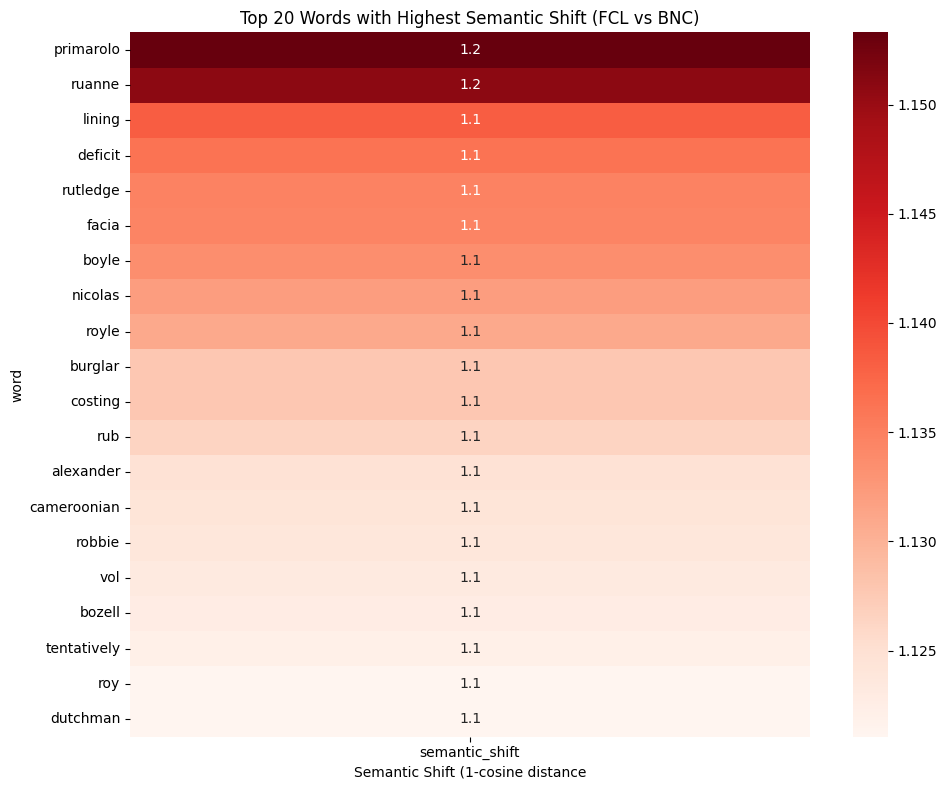

In [36]:
# visualise as dataframe
top_words = shift_df.head(20).set_index("word")

plt.figure(figsize=(10, 8))
sns.heatmap(top_words[["semantic_shift"]], cmap="Reds", annot=True)
plt.title("Top 20 Words with Highest Semantic Shift (FCL vs BNC)")
plt.xlabel("Semantic Shift (1-cosine distance)")
plt.tight_layout()
plt.show()

# STEP 6: Semantic Search Prototype -- did you mean?
Functions to suggest semantic alternatives to potential search queries

## Word2Vec-based Semantic Suggestions

In [14]:
def extract_keyword_w2v(sentence, model):
    doc = nlp(sentence)
    
    # Lemmatize and keep content words (nouns, verbs, adjectives)
    content_words = [token.lemma_.lower() for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ']]

    if not content_words:
        return None

    # Only keep words that are actually in the Word2Vec vocab
    valid_words = [word for word in content_words if word in model.wv]

    if not valid_words:
        return None

    # Find the most "central" word: highest average similarity to others
    sims = []
    for word in valid_words:
        other_words = [w for w in valid_words if w != word]
        if not other_words:
            avg_sim = 0
        else:
            avg_sim = np.mean([model.wv.similarity(word, other) for other in other_words])
        sims.append(avg_sim)

    best_word = valid_words[np.argmax(sims)]
    return best_word

def suggest_search_terms_w2v(word, fcl_model, bnc_model, k=5, threshold=0.5):
    if word not in fcl_model.wv:
        return f"'{word}' not found in the legal corpus. Try another term."

    # Get nearest neighbors from FCL model with scores
    fcl_neighbors = fcl_model.wv.most_similar(word, topn=k*5)  # pull extra, we'll filter

    filtered_neighbors = []
    for neighbor, score in fcl_neighbors:
        if score < threshold:
            continue
        if not neighbor.isalpha() or len(neighbor) < 3 or len(neighbor) > 20:
            continue
        if neighbor.startswith(word) or word.startswith(neighbor):
            if abs(len(neighbor) - len(word)) <= 2:
                continue
        if neighbor in bnc_model.wv:
            bnc_similarity = bnc_model.wv.similarity(word, neighbor)
            if score > bnc_similarity or bnc_similarity < 0.4:
                filtered_neighbors.append((neighbor, score))
        else:
            filtered_neighbors.append((neighbor, score))

    filtered_neighbors.sort(key=lambda x: x[1], reverse=True)
    top_neighbors = filtered_neighbors[:k]

    if not top_neighbors:
        return f"No distinctive legal terms found for '{word}'. Try another term."

    result_terms = [f"{term} ({score:.2f})" for term, score in top_neighbors]
    return f"Suggested legal search terms for '{word}': {', '.join(result_terms)}"

In [15]:
def semantic_suggestions_w2v():
    print("Semantic Suggestions (Word2Vec)")
    print("Type a sentence to find legal-specific related terms. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a sentence: ").strip()
        if user_input.lower() == 'exit':
            break
        keyword = extract_keyword_w2v(user_input, best_fcl_model)

        if not keyword:
            print("Couldn't extract meaningful keyword. Try rephrasing.")
            continue

        print(f"\nDetected keyword: {keyword}")
        print(suggest_search_terms_w2v(keyword, best_fcl_model, best_bnc_model))
        print()

In [16]:
# run - type 'exit' to quit
semantic_suggestions_w2v()

Semantic Suggestions (Word2Vec)
Type a sentence to find legal-specific related terms. Type 'exit' to quit.



Enter a sentence:  contract



Detected keyword: contract
Suggested legal search terms for 'contract': agreement (0.80), clause (0.72), party (0.67), term (0.66), agree (0.66)



Enter a sentence:  partner



Detected keyword: partner
Suggested legal search terms for 'partner': partnership (0.75), firm (0.73), relationship (0.56), joint (0.52), michael (0.52)



Enter a sentence:  knife



Detected keyword: knife
Suggested legal search terms for 'knife': stab (0.87), stabbing (0.80), machete (0.79), brandish (0.76), weapon (0.75)



Enter a sentence:  crime



Detected keyword: crime
Suggested legal search terms for 'crime': offence (0.63), criminality (0.59), organised (0.59), convict (0.57), proceedsof (0.57)



Enter a sentence:  divorce



Detected keyword: divorce
Suggested legal search terms for 'divorce': marriage (0.77), matrimonial (0.71), nisi (0.71), remarry (0.68), wife (0.68)



Enter a sentence:  exit


## BERT-based Semantic Search

In [40]:
def extract_key_word(sentence, model):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    content_words = [word for word, pos in tagged if pos.startswith('N') or pos.startswith('V') or pos.startswith('J')]
    if not content_words:
        return None

    sentence_emb = model.encode([sentence])[0]
    word_embeddings = model.encode(content_words)
    sims = cosine_similarity([sentence_emb], word_embeddings)[0]
    return content_words[np.argmax(sims)].lower()

def get_word_nearest_neighbors(word, model, word_embeddings_dict, k=10):
    if word not in word_embeddings_dict:
        return []

    word_embedding = model.encode([word])[0]
    vocab = list(word_embeddings_dict.keys())
    embeddings = np.array([word_embeddings_dict[w] for w in vocab])
    
    sims = cosine_similarity([word_embedding], embeddings)[0]
    top_k_idx = np.argsort(sims)[::-1][1:k+1]  # skip self
    return [vocab[i] for i in top_k_idx]

def suggest_search_terms(user_sentence):
    keyword = extract_key_word(user_sentence, bert_model)
    if not keyword:
        return "Couldn't extract a meaningful keyword. Try rephrasing."

    print(f"\nDetected keyword: '{keyword}'")

    nn_fcl = get_word_nearest_neighbors(keyword, bert_model, fcl_embeddings)
    nn_bnc = get_word_nearest_neighbors(keyword, bert_model, bnc_embeddings)

    legal_terms = set(nn_fcl) - set(nn_bnc)

    if not legal_terms:
        return f"'{keyword}' has a shift but no clear legal alternatives. Try a broader search."

    return f"Suggested legal search terms for '{keyword}': {', '.join(legal_terms)}"

In [41]:
def semantic_suggestions_bert():
    print("Semantic Search Engine (FCL vs. General English)")
    print("Type a sentence to discover legal alternatives. Type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a sentence: ").strip()
        if user_input.lower() == 'exit':
            break
        print(suggest_search_terms(user_input))
        print()

In [42]:
semantic_suggestions_bert()

Semantic Search Engine (FCL vs. General English)
Type a sentence to discover legal alternatives. Type 'exit' to quit.



Enter a sentence:  parent



Detected keyword: 'parent'
Suggested legal search terms for 'parent': limbless, population, longish, limpness, jointure, lengthorne, partiesis, foecal, swiftness, underweight



Enter a sentence:  judge



Detected keyword: 'judge'
Suggested legal search terms for 'judge': hokkanen, propositus, vaa, gyrus, vomitus, hämäläinen, hannen, hamalainen, jospeh, hokannen



Enter a sentence:  exit


# STEP 7: Visualisations

In [ ]:
# Seamntic Shift heatmap using cosine distance for certain words

# only tracking certian words - pick words to track here
important_words = ["child", "parent", "consent", "removal", "custody", 
                   "adoption", "knife", "welfare", "protection", "authority"]

# Step 1: Define a function to compute semantic shifts for selected words
def compute_semantic_shift_selected(model1, model2, selected_words):
    """Compute cosine similarity between selected words in two Word2Vec models."""
    shift_data = []

    for word in selected_words:
        if word in model1.wv and word in model2.wv:
            vec1 = model1.wv[word]
            vec2 = model2.wv[word]

            cos_sim = cosine_similarity([vec1], [vec2])[0][0]

            shift_data.append({
                "word": word,
                "cosine_similarity": cos_sim,
                "semantic_shift": 1 - cos_sim  # higher = more shift
            })
        else:
            print(f" Word '{word}' not found in both models — skipping.")

    return pd.DataFrame(shift_data)

# Step 2: Calculate semantic shifts
shift_df = compute_semantic_shift_selected(best_fcl_model, best_bnc_model, important_words)

# Step 3: Create a heatmap of the semantic shifts
plt.figure(figsize=(8, 6))

# Set 'word' as index for heatmap
heatmap_data = shift_df.set_index("word")[["semantic_shift"]]

# Plot
sns.heatmap(
    heatmap_data.sort_values(by="semantic_shift", ascending=False), 
    cmap="Reds", 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Semantic Shift (1 - Cosine Similarity)'}
)

plt.title("Semantic Shift Heatmap (Selected Words): FCL vs BNC")
plt.xlabel("Shift Measure")
plt.ylabel("Words (Most Shifted at Top)")
plt.tight_layout()
plt.show()

In [ ]:
def get_neighbors_table(model1, model2, selected_words, topn=5):
    """Create a table showing nearest neighbors in two models for selected words."""
    rows = []

    for word in selected_words:
        if word in model1.wv and word in model2.wv:
            neighbors_model1 = [w for w, _ in model1.wv.most_similar(word, topn=topn)]
            neighbors_model2 = [w for w, _ in model2.wv.most_similar(word, topn=topn)]

            rows.append({
                "Word": word,
                "Top Neighbors in BNC": ", ".join(neighbors_model1),
                "Top Neighbors in FCL": ", ".join(neighbors_model2)
            })
        else:
            print(f" Word '{word}' not found in both models — skipping.")

    return pd.DataFrame(rows)

# create  neighbours comparison table
neighbors_df = get_neighbors_table(best_bnc_model, best_fcl_model, important_words, topn=5)

print(neighbors_df.to_string(index=False))
neighbors_df.to_csv("neighbors_comparison_bnc_fcl.csv", index=False)

In [ ]:
def visualize_word_shift_with_neighbors(word, model1, model2, model1_name="Model1", model2_name="Model2", topn=5):
    """Improved t-SNE visualization with better labels and neighbor connections."""

    words = []
    vectors = []
    colors = []
    groups = [] 

    # collect main word and neighbours from model1
    if word in model1.wv:
        vectors.append(model1.wv[word])
        colors.append('red')
        words.append(f"{word} ({model1_name})")
        groups.append(f"{word} ({model1_name})")

        for neighbor, _ in model1.wv.most_similar(word, topn=topn):
            vectors.append(model1.wv[neighbor])
            colors.append('pink')
            words.append(f"{neighbor} ({model1_name})")
            groups.append(f"{word} ({model1_name})")
    else:
        print(f" Word '{word}' not found in {model1_name}")

    # Collect main word and neighbors from model2
    if word in model2.wv:
        vectors.append(model2.wv[word])
        colors.append('blue')
        words.append(f"{word} ({model2_name})")
        groups.append(f"{word} ({model2_name})")

        for neighbor, _ in model2.wv.most_similar(word, topn=topn):
            vectors.append(model2.wv[neighbor])
            colors.append('lightblue')
            words.append(f"{neighbor} ({model2_name})")
            groups.append(f"{word} ({model2_name})")
    else:
        print(f" Word '{word}' not found in {model2_name}")

    # t-SNE projection
    n_points = len(vectors)
    perplexity = min(5, n_points - 1)  # Always perplexity < n_samples
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced = tsne.fit_transform(np.array(vectors))

    plt.figure(figsize=(12, 10))
    
    # plot the connections
    for idx, group in enumerate(groups):
        if words[idx] != group:
            center_idx = groups.index(group)
            plt.plot(
                [reduced[center_idx, 0], reduced[idx, 0]],
                [reduced[center_idx, 1], reduced[idx, 1]],
                'k-', alpha=0.2  # faint black lines
            )
    # plot points
    for idx, (x, y) in enumerate(reduced):
        if words[idx].startswith(word):
            size = 200  # larger for main word
        else:
            size = 60   # smaller for neighbors
        plt.scatter(x, y, color=colors[idx], s=size, edgecolor='k', alpha=0.9)

        plt.annotate(
            words[idx],
            (x + 1.0, y + 1.0),  # offset a bit to the top-right
            fontsize=9,
            color='black',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        )

    plt.title(f"t-SNE: '{word}' Semantic Neighborhoods in {model1_name} and {model2_name}")
    plt.show()

In [ ]:
visualize_word_shift_with_neighbors(
    word="consent",
    model1=best_fcl_model,
    model2=best_bnc_model,
    model1_name="FCL",
    model2_name="BNC",
    topn=10
)

In [ ]:
def visualize_multiple_words_shift(words_list, model1, model2, model1_name="Model1", model2_name="Model2", topn=5):
    """t-SNE visualization for multiple words with two colors only: blue (model1) and red (model2)."""

    all_words = []
    vectors = []
    colors = []
    groups = []

    for word in words_list:
        # model1: FCL (blue)
        if word in model1.wv:
            vectors.append(model1.wv[word])
            colors.append('blue')
            all_words.append(f"{word} ({model1_name})")
            groups.append(f"{word} ({model1_name})")

            for neighbor, _ in model1.wv.most_similar(word, topn=topn):
                vectors.append(model1.wv[neighbor])
                colors.append('lightblue')
                all_words.append(f"{neighbor} ({model1_name})")
                groups.append(f"{word} ({model1_name})")
        else:
            print(f"⚠️ Word '{word}' not found in {model1_name}")

        # model2: BNC (red)
        if word in model2.wv:
            vectors.append(model2.wv[word])
            colors.append('red')
            all_words.append(f"{word} ({model2_name})")
            groups.append(f"{word} ({model2_name})")

            for neighbor, _ in model2.wv.most_similar(word, topn=topn):
                vectors.append(model2.wv[neighbor])
                colors.append('pink')
                all_words.append(f"{neighbor} ({model2_name})")
                groups.append(f"{word} ({model2_name})")
        else:
            print(f"⚠️ Word '{word}' not found in {model2_name}")

    # t-SNE projection
    n_points = len(vectors)
    perplexity = min(5, n_points - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced = tsne.fit_transform(np.array(vectors))

    # Plot
    plt.figure(figsize=(14, 12))

    # Draw connecting lines
    for idx, group in enumerate(groups):
        if all_words[idx] != group:
            center_idx = groups.index(group)
            plt.plot(
                [reduced[center_idx, 0], reduced[idx, 0]],
                [reduced[center_idx, 1], reduced[idx, 1]],
                'k-', alpha=0.2
            )

    # Plot the points
    for idx, (x, y) in enumerate(reduced):
        if any(all_words[idx].startswith(w) for w in words_list):
            size = 200  # main word bigger
        else:
            size = 60   # neighbors smaller
        plt.scatter(x, y, color=colors[idx], s=size, edgecolor='k', alpha=0.9)

        plt.annotate(
            all_words[idx],
            (x + 1.0, y + 1.0),
            fontsize=9,
            color='black',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        )

    # Add manual legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=model1_name),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=model2_name)
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.title(f"t-SNE: Semantic Shifts for {words_list} in {model1_name} and {model2_name}")
    plt.show()

In [ ]:
visualize_multiple_words_shift(
    words_list=["partner", "consent", "knife"],
    model1=best_fcl_model,
    model2=best_bnc_model,
    model1_name="FCL",
    model2_name="BNC",
    topn=5
)